# Inférence de la Typologie à partir des données de MRV (Stratégie ML Naive)
La variable TYPO présente les types de dysfocntionnements et d'effets des dispositifs. Il y a 3 varaibles concernée
- TYPE DE DYSFONCTIONNEMENT
- CONSEQUENCE DYSFONCTIONNEMENT
- TYPE D'EFFET




**Stratégie ML**

## 0) Chargement des librairies

In [59]:
import warnings
warnings.filterwarnings('ignore')

from pprint import pprint
from time import time
import logging

import pandas as pd

import numpy as np
import sklearn as sk
import seaborn as sns

import nltk
from nltk import word_tokenize
lang ='french'

import clean_text





import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer,HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score, cross_validate

from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score,f1_score
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import TruncatedSVD,IncrementalPCA,SparsePCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
import json
import spacy
nlp =spacy.load('fr')
from spacy.lang.fr.stop_words import STOP_WORDS

## 0.1 Chargement et exploration des données

In [79]:
%time
df_declaration_mrv = pd.read_csv("data/data_mrv/declaration_mrv_complet.csv")#delimiter=';',encoding='ISO-8859-1')
id_to_dco = pd.read_csv("data/ref_MRV/referentiel_dispositif.csv",delimiter=';',encoding='ISO-8859-1')
df_effets = pd.read_csv("data/ref_MRV/referentiel_dispositif_effets_connus.csv",delimiter=';',encoding='ISO-8859-1')
df_dys = pd.read_csv("data/ref_MRV/referentiel_dispositif_dysfonctionnement.csv",delimiter=';',encoding='ISO-8859-1')

with open ('mapping_effet.json', 'r') as file :
    mapping_effet = json.load(file)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.34 µs


In [80]:
df_declaration_mrv.columns

Index(['Unnamed: 0', 'NUMERO_DECLARATION', 'TYPE_DECLARATION',
       'TYPE_DECLARANT', 'NB_PATIENT_CONCERNE', 'NB_DISPOSITIF_CONCERNE',
       'DESCRIPTION_INCIDENT', 'ETAT_PATIENT', 'ACTION_PATIENT', 'DCO_ID',
       'DCO', 'LIBELLE_COMMERCIAL', 'REFERENCE_COMMERCIALE', 'NUMERO_SERIE',
       'NUMERO_LOT', 'FABRICANT', 'MANDATAIRE', 'DISTRIBUTEUR', 'TDY_ID',
       'TYPE_DYSFONCTIONNEMENT', 'CDY_ID', 'CONSEQUENCE_DYSFONCTIONNEMENT',
       'TEF_ID', 'TYPE_EFFET', 'GRAVITE', 'NUMERO', 'TYPE_VIGILANCE',
       'CLASSIFICATION'],
      dtype='object')

In [82]:
%%time
#On complète les effets vide comme étant sans effets
df_declaration_mrv['TYPE_EFFET']  = df_declaration_mrv['TYPE_EFFET'].fillna("PAS D'EFFET NEFASTE DECLARE")
df_declaration_mrv['TEF_ID']= df_declaration_mrv['TEF_ID'].fillna('E1213')


#on selectionne les colonnes avec des effets
df = df_declaration_mrv[['DESCRIPTION_INCIDENT','TYPE_VIGILANCE','LIBELLE_COMMERCIAL',
                         'REFERENCE_COMMERCIALE','ETAT_PATIENT','FABRICANT','DCO_ID',
                         'ACTION_PATIENT','CLASSIFICATION','TYPE_EFFET','TEF_ID']][df_declaration_mrv['TEF_ID']!='E1213']
# On complète les NaN avec du vide
df['ETAT_PATIENT'] = df['ETAT_PATIENT'].fillna("")
df['DESCRIPTION_INCIDENT'] = df['DESCRIPTION_INCIDENT'].fillna("")
df['LIBELLE_COMMERCIAL'] = df['LIBELLE_COMMERCIAL'].fillna("")
df['FABRICANT'] = df['FABRICANT'].fillna("")
df["REFERENCE_COMMERCIALE"] = df['REFERENCE_COMMERCIALE'].fillna("")
df['TYPE_VIGILANCE'] = df['TYPE_VIGILANCE'].fillna("")
df['CLASSIFICATION'] = df['CLASSIFICATION'].fillna('')
df['DCO_ID'] = df['DCO_ID'].fillna(-1)
#On nettoieles variables textueelles : 

for col in  ['DESCRIPTION_INCIDENT','LIBELLE_COMMERCIAL','ETAT_PATIENT','FABRICANT','ACTION_PATIENT'] :
    df[col] = df[col].map(lambda x: clean_text.preprocess_text(x))

def apply_mapping(x,mapping):
    cle = list(mapping.keys())
    if x in cle:
        return(x)
    else:
        for elt in cle:
            if x in mapping[elt] :
                return elt

n = 15
# On filtre pour a voir plus de n observations par classse
df = df.groupby("TEF_ID").filter(lambda x: len(x) > n)

print(len(df.groupby("TYPE_EFFET")))
df.TYPE_EFFET = df.TYPE_EFFET.map(lambda x: apply_mapping(x,mapping_effet))
print(len(df.groupby("TYPE_EFFET")))

le = LabelEncoder()
df.TYPE_VIGILANCE = le.fit_transform(df.TYPE_VIGILANCE.values)
le = LabelEncoder()
df.TYPE_EFFET = le.fit_transform(df.TYPE_EFFET.values)


# Encodage des varaible catégorielle

# selection des train et test set
train_index,test_index = next(GroupShuffleSplit(random_state=1029).split(df, groups=df['DESCRIPTION_INCIDENT']))
df_train, df_test = df.iloc[train_index], df.iloc[test_index]
y = df_train.TYPE_EFFET
y_test =df_test.TYPE_EFFET



172
145
CPU times: user 14 s, sys: 4 ms, total: 14 s
Wall time: 14 s


In [ ]:
# baseline
print('Il y a ',len(df.# baseline
print('Il y a ',len(df.TEF_ID.unique()),'classes'.unique()),'classes'

In [5]:
# baseline
print('Il y a ',len(df.TEF_ID.unique()),'classes')

Il y a  172 classes


In [6]:
df.groupby('TEF_ID').count()['DCO_ID'].describe()

count     172.000000
mean      269.040698
std       509.509985
min        16.000000
25%        31.750000
50%        75.000000
75%       236.500000
max      3342.000000
Name: DCO_ID, dtype: float64

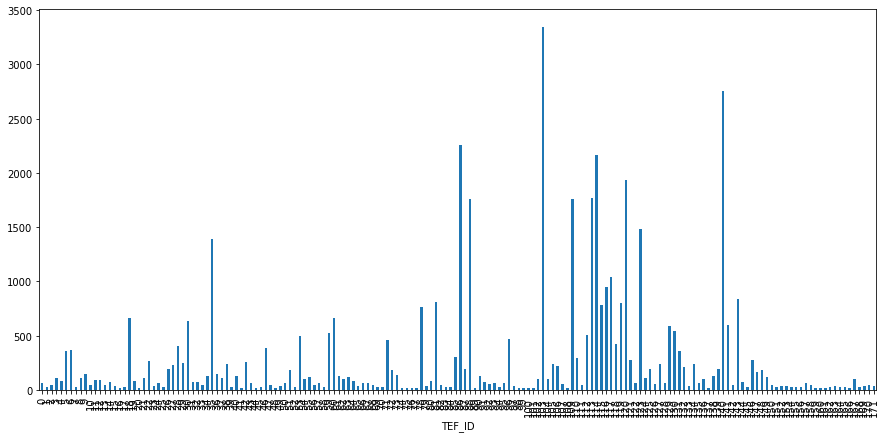

In [7]:
df.groupby('TEF_ID').count()['DCO_ID'].plot(kind='bar',figsize =(15,7))

In [ ]:
select = df_declaration_mrv[['TYPE_EFFET','DESCRIPTION_INCIDENT']][df_declaration_mrv['TEF_ID']!='E1213']
for elt in select.index[:100] :
    x = select.loc[elt]
    print('TYPE EFFET :', x['TYPE_EFFET'])
    print('Description :', x['DESCRIPTION_INCIDENT'])
    print('####################')

In [290]:
%%time
preprocess = ColumnTransformer(
    [('description_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=3,
                            ngram_range=(1, 1),
                            stop_words=STOP_WORDS,
                            max_features = 10000,norm = 'l2'), 'DESCRIPTION_INCIDENT'),
     
     ('etat_pat_tfidf', TfidfVectorizer(sublinear_tf=True, min_df=3,ngram_range=(1, 1),
                                       stop_words=STOP_WORDS,
                                       max_features = 10000,norm = 'l2'), 'ETAT_PATIENT'),
     
     ('fabricant_tfidf',TfidfVectorizer(sublinear_tf=True, min_df=3,
                            ngram_range=(1, 1),
                            stop_words=STOP_WORDS,
                            max_features = 5000,norm = 'l2'), 'FABRICANT'),
    
    ('classification_enc', TfidfVectorizer(sublinear_tf=True, min_df=5,
                            ngram_range=(1, 1),
                            stop_words=STOP_WORDS,
                            max_features = 100,norm = 'l2'),'CLASSIFICATION')
     ],
    
    remainder='passthrough')


pipeline = Pipeline([
    ('vect', preprocess),
    ('clf', BaggingClassifier(SVC(C= 10, gamma= 0.001),n_estimators =10,n_jobs=-1,bootstrap_features = True)),
     #MultinomialNB()),#CalibratedClassifierCV(LinearSVC(class_weight='balanced'),cv=3, method='isotonic')),
])

CV = 5
X = df_train[['FABRICANT','CLASSIFICATION','TYPE_VIGILANCE','DESCRIPTION_INCIDENT','ETAT_PATIENT']]
result= cross_validate(pipeline, X, y, scoring=['accuracy','balanced_accuracy','f1_weighted' ], cv=CV)

CPU times: user 33.2 s, sys: 10.4 s, total: 43.7 s
Wall time: 59min 23s


In [291]:
pd.DataFrame(result)[['test_accuracy','test_balanced_accuracy','test_f1_weighted']].mean()

test_accuracy             0.209582
test_balanced_accuracy    0.033787
test_f1_weighted          0.104358
dtype: float64

In [274]:
%%time
pipeline.fit(X,y)
X_test = df_test[['FABRICANT','CLASSIFICATION','TYPE_VIGILANCE','DESCRIPTION_INCIDENT','ETAT_PATIENT']]
y_pred = pipeline.predict(X_test)

CPU times: user 6.67 s, sys: 80 ms, total: 6.75 s
Wall time: 6.75 s


In [ ]:
BaggingClassifier(SVC(C= 10, gamma= 0.001),n_estimators =10,njobs=-1,bootstrap_features = True)

In [280]:
nb = pd.DataFrame()
nb['pred'] = le.inverse_transform(y_pred)
nb['class_name'] = nb['pred'].map(mapping)

In [285]:
nb.groupby(["class_name"]).count()['pred'].sort_values(ascending=False)/len(y_pred)

class_name
SYMPTOMES MULTIPLES                           0.471184
RETARD AU TRAITEMENT                          0.184798
CHIRURGIE DE REVISION                         0.128002
RETRAIT CHIRURGICAL                           0.102840
REACTION ALLERGIQUE                           0.026415
DOULEUR                                       0.016079
HYPERGLYCEMIE                                 0.013677
DECES                                         0.012215
PERTE DE SANG                                 0.011798
REINTERVENTION NON CHIRURGICALE               0.008457
BRULURE                                       0.006473
DOULEUR PELVIENNE OU  ABDOMILE                0.004176
CHUTE                                         0.003445
SAIGNEMENT / HEMATOME                         0.003132
INFLAMMATION                                  0.003028
AES / RISQUE D'AES                            0.001253
 ( PARTIE DE) DM NON RETIRE / NON EXPLANTE    0.000940
RÃIMPLANTATION CHIRURGICALE Ã RÃALISER     0.000835

In [220]:
N = []
I = []
for elt in y_test :
    if elt in y :
        I.append(elt)
    else :
        N.append(elt)

In [238]:
train = set(y)
test =set(y_test)
pred = set(y_pred)
len(test)

167

In [256]:
jam = pd.DataFrame()
jam['class'] = list(test-pred)
jam['class_name'] = le.inverse_transform(jam['class'].values)
jam['Type_effet'] = jam['class_name'].map(mapping)

tjs = pd.DataFrame()
tjs['class'] = list(test-(test-pred))
tjs['class_name'] = le.inverse_transform(tjs['class'].values)
tjs['Type_effet'] = tjs['class_name'].map(mapping)

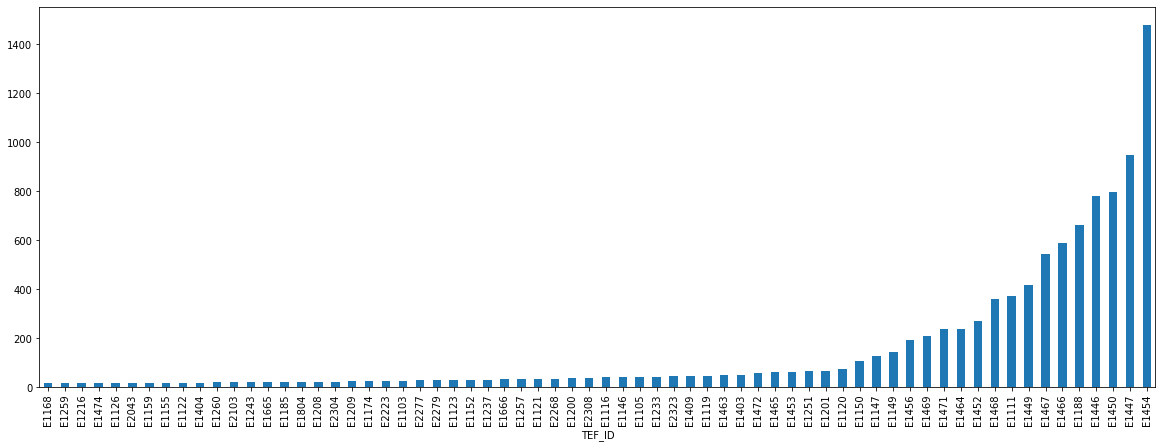

In [264]:
L = df_declaration_mrv.groupby('TEF_ID').count().loc[jam['class_name'].values]['DCO_ID'].sort_values()
L =L#/1500
L.plot(kind='bar',figsize =(20,7))
plt.show()

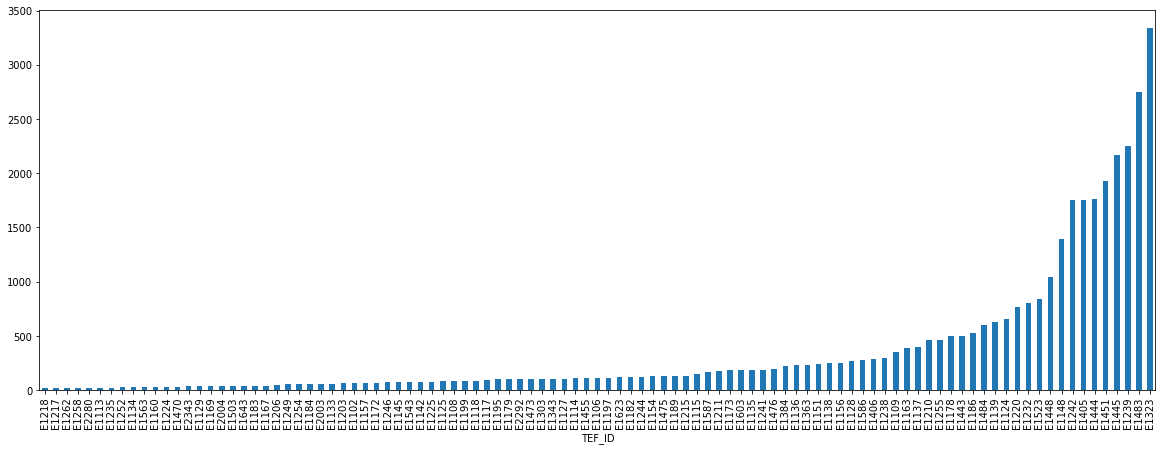

In [265]:
L = df_declaration_mrv.groupby('TEF_ID').count().loc[tjs['class_name'].values]['DCO_ID'].sort_values()
L =L#/3500
L.plot(kind='bar',figsize =(20,7))
plt.show()

In [269]:
 df_declaration_mrv.groupby('TEF_ID').count().loc[tjs['class_name'].values]['DCO_ID'].describe()

count     101.000000
mean      357.524752
std       614.007127
min        17.000000
25%        59.000000
50%       112.000000
75%       290.000000
max      3342.000000
Name: DCO_ID, dtype: float64

In [252]:
df_declaration_mrv.groupby('TEF_ID').loc[jam['class_name'].values]['DCO_ID']

,Unnamed: 0,NUMERO_DECLARATION,TYPE_DECLARATION,TYPE_DECLARANT,NB_PATIENT_CONCERNE,NB_DISPOSITIF_CONCERNE,DESCRIPTION_INCIDENT,ETAT_PATIENT,ACTION_PATIENT,DCO_ID,...,DISTRIBUTEUR,TDY_ID,TYPE_DYSFONCTIONNEMENT,CDY_ID,CONSEQUENCE_DYSFONCTIONNEMENT,TYPE_EFFET,GRAVITE,NUMERO,TYPE_VIGILANCE,CLASSIFICATION
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,...,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,281.882784,281.882784,281.882784,281.882784,152.776557,137.637363,281.846154,275.164835,242.553114,281.838828,...,170.695971,183.267399,183.267399,85.904762,85.904762,281.882784,271.131868,281.882784,281.882784,280.597070
std,1861.757369,1861.757369,1861.757369,1861.757369,835.751118,849.700118,1861.405633,1841.629281,1704.820949,1861.050143,...,878.961197,1646.576155,1646.576155,358.695295,358.695295,1861.757369,1705.684199,1861.757369,1861.757369,1856.404882
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,7.000000,7.000000,7.000000,7.000000,4.000000,4.000000,7.000000,7.000000,6.000000,7.000000,...,3.000000,4.000000,4.000000,0.000000,0.000000,7.000000,7.000000,7.000000,7.000000,7.000000
50%,29.000000,29.000000,29.000000,29.000000,15.000000,15.000000,29.000000,29.000000,26.000000,29.000000,...,14.000000,17.000000,17.000000,4.000000,4.000000,29.000000,28.000000,29.000000,29.000000,29.000000
75%,112.000000,112.000000,112.000000,112.000000,61.000000,55.000000,112.000000,112.000000,100.000000,112.000000,...,57.000000,58.000000,58.000000,25.000000,25.000000,112.000000,112.000000,112.000000,112.000000,108.000000
max,30127.000000,30127.000000,30127.000000,30127.000000,13163.000000,13666.000000,30121.000000,29849.000000,27740.000000,30115.000000,...,13460.000000,26976.000000,26976.000000,4688.000000,4688.000000,30127.000000,27478.000000,30127.000000,30127.000000,30044.000000


In [222]:
len(np.unique(N))

91

In [225]:
76/(76+91)

0.4550898203592814

In [223]:
df_transf

NameError: name 'df_transform' is not defined

In [69]:
%%time
pipeline.fit(X,y)
X_test = df_test[['FABRICANT','CLASSIFICATION','TYPE_VIGILANCE','DESCRIPTION_INCIDENT','ETAT_PATIENT']]
y_pred = pipeline.predict(X_test)



CPU times: user 1min 50s, sys: 108 ms, total: 1min 50s
Wall time: 1min 50s


In [187]:
%%time
C = confusion_matrix(y_test,y_pred, labels = le.classes_)

ValueError: At least one label specified must be in y_true

In [98]:
recall = []
precision = [] 
for i in range(len(C)):
    r = (C[i,i])/np.sum(C[:,i])
    p = C[i,i]/np.sum(C[i,:])
    recall.append(r)
    precision.append(p)

In [183]:
le.inverse_transform([169])

array(['E2308'], dtype=object)

In [99]:
result = pd.DataFrame()
result['class'] = np.arange(len(C))
result['class_name'] = le.inverse_transform(result['class'].values)
result['Recall'] = recall
result['precision'] =precision

In [136]:
mapping = {}
l = df_effets.groupby('TEF_ID')
for group in l.groups :
    mapping['E'+str(group)] = str(l.get_group(group)['TYPE_EFFET'].values[0])

result['TYPE_EFFET'] = result['class_name'].map(mapping)

In [102]:
result['Recall'].mean()

0.40282128851432614

In [160]:
df = pd.DataFrame(df_compare.groupby(['True']).count()['Prediction'])

In [161]:
df['class_name'] = df.index
df['count'] = df.Prediction
df = df.drop('Prediction',axis=1)

In [163]:
df_t = pd.merge(result,df,on='class_name')

In [173]:
df_t['prop'] = df_t['count'].map(lambda x : x/len(y_test))
result = df_t

In [176]:
result.to_csv('Analyse_par_classe.csv')

In [174]:

result.sort_values('Recall').head(30)

,class,class_name,Recall,precision,TYPE_EFFET,count,prop
162,167,E2292,0.000000,0.000000,TEMPS CHIRURGICAL ALLONGE,21,0.002193
62,62,E1195,0.000000,0.000000,LESION CUTANEE,15,0.001566
67,67,E1203,0.000000,0.000000,METALLOSE,11,0.001148
77,78,E1220,0.000000,0.000000,PERTE DE SANG,131,0.013677
92,93,E1251,0.000000,0.000000,THROMBOSE,1,0.000104
100,101,E1262,0.000000,0.000000,RETARD CICATRISATION,9,0.000940
56,56,E1183,0.000000,0.000000,HYPOGLYCEMIE SEVERE,2,0.000209
115,116,E1447,0.000000,0.000000,SF ORL,242,0.025266
131,132,E1469,0.000000,0.000000,SF URIIRE,31,0.003237
102,103,E1323,0.000000,0.000000,SYMPTOMES MULTIPLES,732,0.076425


In [175]:
#result['TYPE_EFFET'] = result['class_name'].map(mapping)
result.sort_values('Recall',ascending=False).head(30)

,class,class_name,Recall,precision,TYPE_EFFET,count,prop
71,71,E1210,1.000000,0.030000,NON RENSEIGNE,100,0.010441
4,4,E1108,1.000000,0.034483,AES,29,0.003028
158,163,E2268,1.000000,0.142857,EXPLANTATION CHIRURGICALE DU DM,5,0.000522
81,82,E1233,1.000000,0.600000,REACTION INDESIRABLE PDT / APRES PROCEDURE,10,0.001044
157,162,E2223,1.000000,0.714286,DEHISCENCE,2,0.000209
136,137,E1474,1.000000,0.043478,MASSE,1,0.000104
19,19,E1125,1.000000,0.166667,CANCER,12,0.001253
49,49,E1169,0.800000,0.615385,PIEGEAGE,13,0.001357
143,144,E1543,0.800000,1.000000,EXPOSITION,13,0.001357
104,105,E1363,0.793103,0.605263,EXPLANTATION SS SIGNE CLINIQUE OU RADIO,55,0.005742


In [177]:
result['prop'].sum()

0.9955105449989561

In [178]:
result.sort_values('prop',ascending=False).head(30)

,class,class_name,Recall,precision,TYPE_EFFET,count,prop
102,103,E1323,0.000000,0.000000,SYMPTOMES MULTIPLES,732,0.076425
139,140,E1483,0.568807,0.760736,CHIRURGIE DE REVISION,525,0.054813
113,114,E1445,NaN,0.000000,DOULEUR NON GYNECO,486,0.050741
85,86,E1239,0.294118,0.131579,RETARD AU TRAITEMENT,454,0.047400
119,120,E1451,NaN,0.000000,FATIGUE,434,0.045312
87,88,E1242,NaN,0.000000,SAIGNEMENT / HEMATOME,425,0.044373
112,113,E1444,0.127764,0.106996,DOULEUR PELVIENNE OU ABDOMILE,371,0.038735
108,109,E1405,0.700000,0.538462,RETRAIT CHIRURGICAL,361,0.037691
122,123,E1454,0.333333,0.136364,AUTRE,296,0.030904
35,35,E1148,0.314371,0.368421,DOULEUR,285,0.029756


In [94]:
print('Justesse:',accuracy_score(y_pred,y_test))
print('Justesse pondéré: ', balanced_accuracy_score(y_pred,y_test))

Justesse: 0.3075798705366465
Justesse pondéré:  0.4028212885143262


In [71]:
cm =pd.crosstab(y_test.values, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

In [72]:
for iin range(len)

Predicted,0,3,4,5,7,8,9,11,12,18,...,148,149,150,153,157,158,166,167,171,All
True,,,,,,,,,,,,,,,,,,,,,
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,15
3,0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,18
4,0,0,1,13,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
169,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
170,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14


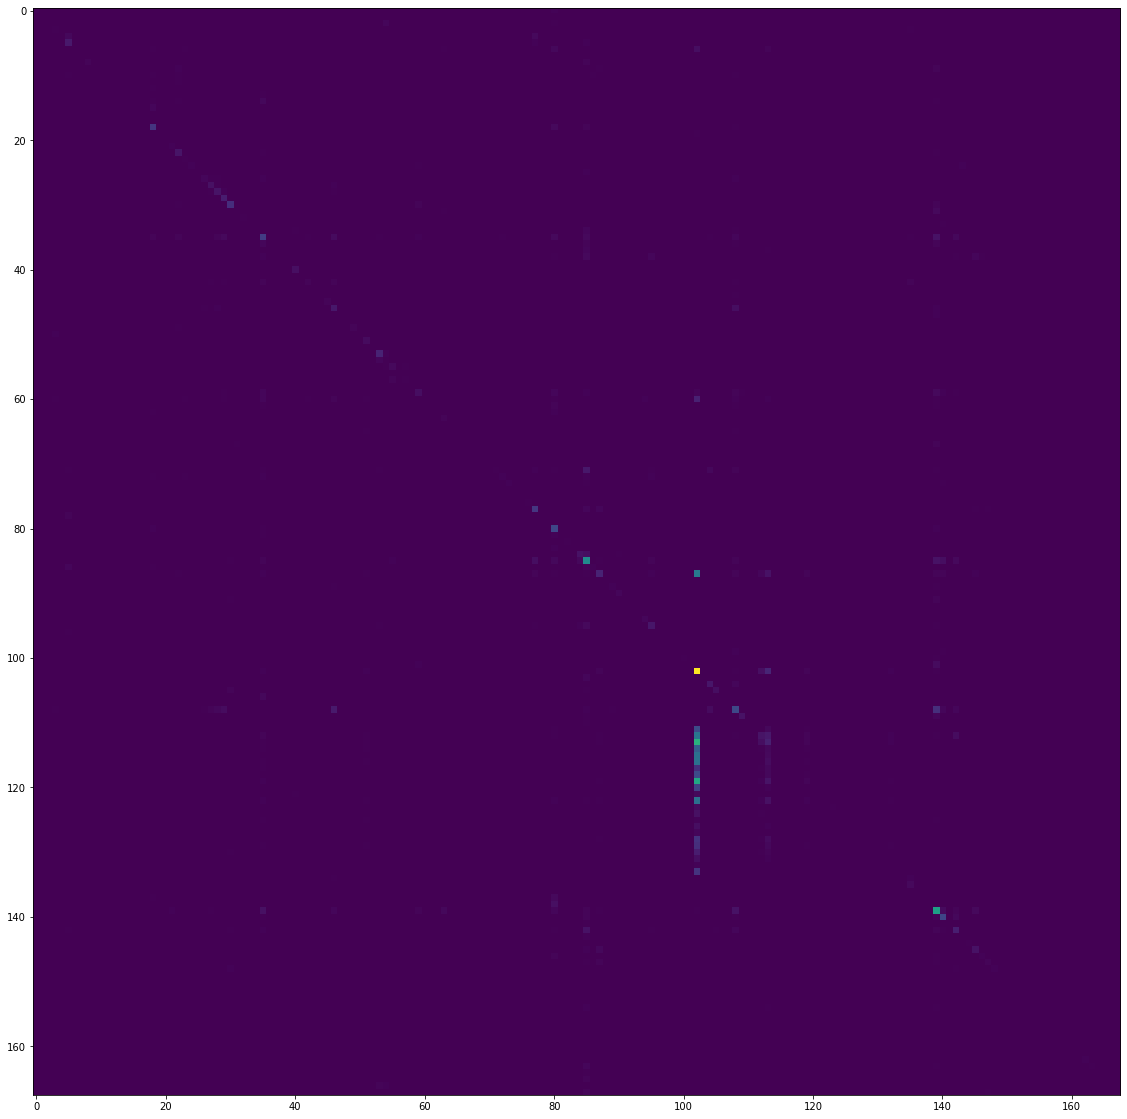

In [62]:
plt.figure(figsize=(20,20))
plt.imshow(C)

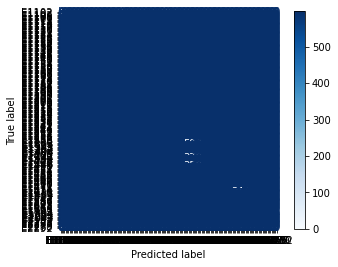

In [60]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipeline, X_test, y_test,
                                 display_labels=le.classes_,
                                 cmap=plt.cm.Blues)

True
E1102    16
E1103     4
E1105    15
E1106    18
E1108    29
         ..
E2292    21
E2304     4
E2308    11
E2323    14
E2343    14
Name: Prediction, Length: 167, dtype: int64

In [39]:
y_pred_prob = pipeline.predict_proba(X_test)
K=[]
for elt in y_pred_prob :
    L = np.argsort(elt)
    L_t=le.inverse_transform(L)[::-1]
    K.append(L_t)

In [40]:
df_compare['list_pred'] = K

In [41]:
def compareK(x,col1,col2,k):
    if df_compare[col1].iloc[x]  in df_compare[col2].iloc[x][:k] :
        return 1
    else :
        return 0

def scoreK(df_compare,k):
    df_compare['score'] = df_compare.index.map(lambda x :compareK(x,'True','list_pred',k))
    t = len(df_compare[df_compare['score']==1])
    return(t/len(df_compare['score']))

In [52]:
for k in range(36):
    print('Précision à  ',k,': ',scoreK(df_compare,k))

Précision à   0 :  0.0
Précision à   1 :  0.3075798705366465
Précision à   2 :  0.44038421382334514
Précision à   3 :  0.5267279181457507
Précision à   4 :  0.5936521194403842
Précision à   5 :  0.648778450615995
Précision à   6 :  0.6982668615577364
Précision à   7 :  0.7296930465650449
Précision à   8 :  0.7637293798287743
Précision à   9 :  0.7959908122781374
Précision à   10 :  0.8215702651910628
Précision à   11 :  0.8362915013572771
Précision à   12 :  0.8485069951973272
Précision à   13 :  0.8596784297348089
Précision à   14 :  0.8715807057840885
Précision à   15 :  0.879097932762581
Précision à   16 :  0.8856755063687618
Précision à   17 :  0.8916266443934016
Précision à   18 :  0.8969513468365004
Précision à   19 :  0.902276049279599
Précision à   20 :  0.9068699102109
Précision à   21 :  0.911359365211944
Précision à   22 :  0.9150135727709334
Précision à   23 :  0.9264982250991857
Précision à   24 :  0.9305700563792023
Précision à   25 :  0.9341198580079348
Précision à   26 

In [ ]:
print('Justesse:',accuracy_score(y_pred,y_test))
print('Justesse pondéré: ', balanced_accuracy_score(y_pred,y_test))
print('f1_weighted : ',f1_score(y_pred,y_test,average='weighted'))

In [12]:
Possible = []
x = df_test[['FABRICANT','CLASSIFICATION','TYPE_VIGILANCE','DESCRIPTION_INCIDENT','ETAT_PATIENT','DCO_ID']]
group = df_effets.groupby('DCO_ID')
for index in x.index :
        try :
            ligne = x.loc[index]
            effet_possible = group.get_group(int(ligne['DCO_ID']))['TEF_ID']
            effet_possible = effet_possible.map(lambda x:'E'+str(x))
            #enc_effet = le.transform(effet_possible.values)
            Possible.append(effet_possible.values)
        except :
            Possible.append([])

In [13]:
df_compare = pd.DataFrame()
df_compare['True'] = le.inverse_transform(y_test)
df_compare['Prediction'] = le.inverse_transform(y_pred)
df_compare['Possible'] = Possible 
df_compare['description'] = df_test['DESCRIPTION_INCIDENT'].to_list()

In [224]:
len(df_compare[df_compare['Possible'].map(lambda x : len(x)>0)])/len(df_compare)

0.9996867822092295

In [224]:
df_compare

,True,Prediction,Possible,description,true_pos,pred_pos,list_pred,score,len
0,E1220,E1220,"[E1220, E1213, E1586, E1148, E1108, E1109, E12...",la pince kocher présente dans la trousse a été...,1,1,"[E1220, E1148, E1405, E1239, E1242, E1586, E14...",1,8
1,E1111,E1483,"[E1475, E1405, E1484, E1249, E1128, E1239, E14...",date de survenue : mi juillet suspicion de dre...,1,1,"[E1483, E1451, E1182, E1239, E1444, E1255, E14...",1,51
2,E1111,E1483,"[E1475, E1405, E1484, E1249, E1128, E1239, E14...",date de survenue : mi juillet suspicion de dre...,1,1,"[E1483, E1451, E1182, E1239, E1444, E1255, E14...",1,51
3,E1242,E1586,"[E1242, E1114, E1215, E1116, E1148, E1103, E15...",pinces grippées provoquant des hémorragies lor...,1,1,"[E1586, E1239, E1603, E1242, E1483, E1445, E12...",1,21
4,E1239,E1239,"[E1146, E1252, E1150, E1242, E1251, E1213, E11...","lors de embolisation une fistule durale , le d...",1,1,"[E1239, E1246, E1238, E1451, E1563, E1454, E12...",1,18
...,...,...,...,...,...,...,...,...,...
9573,E1120,E1128,"[E1119, E1148, E1118, E1213]",le dm en ouvrant est cassé,0,0,"[E1128, E1242, E1109, E1323, E1186, E1451, E14...",1,4
9574,E1242,E1128,"[E1119, E1148, E1118, E1213]",le dm en ouvrant est cassé,0,0,"[E1128, E1242, E1109, E1323, E1186, E1451, E14...",1,4
9575,E1405,E1405,"[E1188, E1198, E1163, E1208, E1363, E1136, E12...","patiente de ans , opérée pour explantation imp...",1,1,"[E1405, E1163, E1137, E1323, E1483, E1148, E14...",1,58
9576,E2292,E1239,"[E1146, E1603, E1210, E1147, E1251, E1112, E11...",stent advanta mmxx cm bloqué dans introducteur...,0,1,"[E1239, E1484, E1483, E1323, E1242, E1150, E14...",1,27


In [14]:
def compare(x,col1,col2):
    if df_compare[col1].iloc[x]  in df_compare[col2].iloc[x] :
        return 1
    else :
        return 0
    
df_compare['true_pos'] = df_compare.index.map(lambda x :compare(x,'True','Possible'))
df_compare['pred_pos'] = df_compare.index.map(lambda x :compare(x,'Prediction','Possible'))


In [219]:
print(len(df_compare[df_compare['true_pos']==1])/len(df_compare), 'des véritables valeures sont dans les possibles')
print(len(df_compare[df_compare['pred_pos']==1])/len(df_compare), 'des prédictions sont dans les possibles')

0.9160576320735018 des véritables valeures sont dans les possibles
0.9544790144080184 des prédictions sont dans les possibles


In [22]:
#df_compare=pd.read_csv('Analyse_erreur.csv')
df_false = df_compare[df_compare['True']!=df_compare['Prediction']]
print(len(df_false)/len(df_compare))


0.6924201294633535


In [50]:
len(df_false[df_false['pred_pos']==1])/len(df_false)

0.9393848009650181

In [51]:
df_compare['len'] = df_compare['Possible'].map(lambda x : len(x))
df_compare['len'].describe()

count    9578.000000
mean       36.971602
std        19.699577
min         0.000000
25%        19.000000
50%        48.000000
75%        52.000000
max        67.000000
Name: len, dtype: float64

In [17]:
df_compare.to_csv('Analyse_erreur.csv')

In [231]:
df_effets[df_effets['TEF_ID']==1323]

,DCO_ID,DCO,TEF_ID,TYPE_EFFET
1953,2965.0,PROTHESE MAMMAIRE IMPLANTABLE,1323,SYMPTOMES MULTIPLES
2167,3050.0,XGASTROSTOMIE PERCUTANEE ENDOSCOPIQUE ( SONDE ),1323,SYMPTOMES MULTIPLES
2242,3961.0,CHOIX INSTRUCTEUR AUBRIERE,1323,SYMPTOMES MULTIPLES
2268,2434.0,DISPOSITIF D' ABLATION DE L' ENDOMETRE,1323,SYMPTOMES MULTIPLES
2308,2457.0,RENFORT PARIETAL/TREILLIS,1323,SYMPTOMES MULTIPLES
2553,2742.0,VENTILATEUR DE REANIMATION,1323,SYMPTOMES MULTIPLES
2674,2577.0,IMPLANT POUR STERILISATION TUBAIRE,1323,SYMPTOMES MULTIPLES
2762,2974.0,PMI : SILICONE LISSE,1323,SYMPTOMES MULTIPLES
4127,2333.0,CHIRURGIE ASSISTEE PAR ORDITEUR,1323,SYMPTOMES MULTIPLES
4461,4482.0,CLIPS POUR STERILISATION TUBAIRE,1323,SYMPTOMES MULTIPLES


In [81]:
ligne[['FABRICANT','CLASSIFICATION','TYPE_VIGILANCE',
                                  'DESCRIPTION_INCIDENT','ETAT_PATIENT']]

FABRICANT                                                           vygon
CLASSIFICATION          Autre type d'incident donnant lieu à un signal...
TYPE_VIGILANCE                                                          0
DESCRIPTION_INCIDENT    la pince kocher présente dans la trousse a été...
ETAT_PATIENT            perte sanguine du bébé , la pince ne réalisant...
Name: 5, dtype: object

In [138]:
x = df_test[['FABRICANT','CLASSIFICATION','TYPE_VIGILANCE','DESCRIPTION_INCIDENT','ETAT_PATIENT','DCO_ID']]
ligne = x.iloc[0]
effet_possible = group.get_group(int(ligne['DCO_ID']))['TEF_ID']
effet_possible =effet_possible[effet_possible != 1213]
effet_possible = effet_possible.map(lambda x:'E'+str(x))
#enc_effet = le.transform(effet_possible.values)
x_test = ligne[['FABRICANT','CLASSIFICATION','TYPE_VIGILANCE','DESCRIPTION_INCIDENT','ETAT_PATIENT']]
y_pred = pipeline.predict_proba(pd.DataFrame(x_test).T)

In [104]:
result = pd.DataFrame(data = y_pred[0],index = le.classes_)
y = enc_effet[np.argmax(y_pred[0][enc_effet])]

In [158]:
def predict_with_dict(X,pipeline,df_effets,le):
    group = df_effets.groupby('DCO_ID')
    df_effets['TEF_ID']=df_effets['TEF_ID'].map(lambda x:'E'+str(x))
    df_effets = df_effets[df_effets['TEF_ID'].isin(le.classes_)]
    Y = []
    for index in X.index :
        try :
            ligne = X.loc[index]
            effet_possible = group.get_group(int(ligne['DCO_ID']))['TEF_ID']
            effet_possible =effet_possible[effet_possible != 'E1213']
            effet_possible = effet_possible[effet_possible.isin(le.classes_)]
            enc_effet = le.transform(effet_possible.values)
            x_test = ligne[['FABRICANT','CLASSIFICATION','TYPE_VIGILANCE','DESCRIPTION_INCIDENT','ETAT_PATIENT']]
            y_pred = pipeline.predict_proba(pd.DataFrame(x_test).T)
            result = pd.DataFrame(data = y_pred[0],index = np.arange(len(y_pred[0])))
        
            y = enc_effet[np.argmax(y_pred[0][enc_effet])]
            Y.append(y)
        except :
            print(enc_effet)
            print(ligne['DCO_ID'])
            Y.append(0)
    return(Y)

In [159]:
%%time
df_effets = pd.read_csv("data/ref_MRV/referentiel_dispositif_effets_connus.csv",delimiter=';',encoding='ISO-8859-1')
x = df_test[['FABRICANT','CLASSIFICATION','TYPE_VIGILANCE','DESCRIPTION_INCIDENT','ETAT_PATIENT','DCO_ID']]
y_pred_2 = predict_with_dict(x,pipeline,df_effets,le)

[]
4926.0
[]
4926.0
[]
4926.0
[ 31  60 140  35  63  61  36  81 107  67  70 111 104  68 143  48 100  86
 154  59  71  43]
5021.0
[]
4926.0
[]
4926.0
[]
4926.0
[]
4926.0
[]
4926.0
[]
4926.0
[]
4926.0
[]
4926.0
[]
4926.0
[]
4926.0
[ 99  13  30  49 149   9  17  14 143  10  87  88  22  71  45  72  35 150
  11  44]
5141.0
[]
4926.0
[]
4926.0
[]
4926.0
[]
2814.0
[]
4926.0
[  6 140  59  36 123  71  35  88 109  48 143  67  31  60  72  39  42  81
  70 111  63  61]
4921.0
CPU times: user 19min 37s, sys: 1.13 s, total: 19min 38s
Wall time: 19min 37s


In [234]:
 df_effets.groupby('DCO_ID')['DCO'].count().describe()

count    1259.000000
mean        7.817315
std         9.175986
min         1.000000
25%         2.000000
50%         5.000000
75%        10.000000
max        67.000000
Name: DCO, dtype: float64

In [161]:
print('Justesse:',accuracy_score(y_pred_2,y_test))
print('Justesse pondéré: ', balanced_accuracy_score(y_pred_2,y_test))
print('f1_weighted : ',f1_score(y_pred_2,y_test,average='weighted'))

Justesse: 0.31426185007308416
Justesse pondéré:  0.4439944202498897
f1_weighted :  0.37760754998138896


In [91]:
x_test = ligne[['FABRICANT','CLASSIFICATION','TYPE_VIGILANCE','DESCRIPTION_INCIDENT','ETAT_PATIENT']]
pd.DataFrame(x_test).T

,FABRICANT,CLASSIFICATION,TYPE_VIGILANCE,DESCRIPTION_INCIDENT,ETAT_PATIENT
5,vygon,Autre type d'incident donnant lieu à un signal...,0,la pince kocher présente dans la trousse a été...,"perte sanguine du bébé , la pince ne réalisant..."


In [75]:
effet_possible

199     E1220
2273    E1586
5369    E1148
5904    E1108
6565    E1109
7430    E1210
7709    E1242
Name: TEF_ID, dtype: object

## Optuna 

In [120]:
import optuna
from optuna import Trial

def objective(trial):    
    
    train_index,test_index = next(GroupShuffleSplit(random_state=1029).split(X, groups=X['DESCRIPTION_INCIDENT']))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    #Etat Patient
    #vect__etat_pat_tfidf__analyzer = trial.suggest_categorical('vect__etat_pat_tfidf__analyzer', ['word', 'char', 'char_wb']) 
    vect__etat_pat_tfidf__max_features = trial.suggest_int('vect__etat_pat_tfidf__max_features', 500, 20_000)
    vect__etat_pat_tfidf__min_df =  trial.suggest_int('vect__etat_pat_tfidf__min_df', 1,5)
    vect__etat_pat_tfidf__norm = trial.suggest_categorical('vect__etat_pat_tfidf__norm', ('l1', 'l2'))
    #Description
    #vect__description_tfidf__analyzer = trial.suggest_categorical('vect__description_tfidf__analyzer', ['word', 'char', 'char_wb']) 
    vect__description_tfidf__max_features = trial.suggest_int('vect__description_tfidf__max_features', 1500, 60_000)
    vect__description_tfidf__min_df =  trial.suggest_int('vect__description_tfidf__min_df', 1,5)
    vect__description_tfidf__norm = trial.suggest_categorical('vect__description_tfidf__norm', ('l1', 'l2'))
    #Fabricant
    vect__fabricant_tfidf__analyzer = trial.suggest_categorical('vect__fabricant_tfidf__analyzer', ['word', 'char', 'char_wb']) 
    vect__fabricant_tfidf__max_features = trial.suggest_int('vect__fabricant_tfidf__max_features', 500, 10_000)
    vect__fabricant_tfidf__min_df =  trial.suggest_int('vect__fabricant_tfidf__min_df', 1,5)
    vect__fabricant_tfidf__norm = trial.suggest_categorical('vect__fabricant_tfidf__norm', ('l1', 'l2'))
    #action patient
    
    #Classification
    vect__action_pat_tfidf__analyzer = trial.suggest_categorical('vect__action_pat_tfidf__analyzer', ['word', 'char', 'char_wb']) 
    vect__classification_enc__max_features = trial.suggest_int('vect__classification_enc__max_features', 500, 5000)
    vect__classification_enc__min_df =  trial.suggest_int('vect__classification_enc__min_df', 1,5)
    vect__classification_enc__norm = trial.suggest_categorical('vect__classification_enc__norm', ('l1', 'l2'))
    
    #clf__C =trial.suggest_loguniform('svr_c', 1e-5, 1e5)
    

    
    params = {
        #'vect__etat_pat_tfidf__analyzer':vect__etat_pat_tfidf__analyzer,
        'vect__etat_pat_tfidf__max_features': vect__etat_pat_tfidf__max_features,
        'vect__etat_pat_tfidf__min_df':vect__etat_pat_tfidf__min_df,
        'vect__etat_pat_tfidf__norm':vect__etat_pat_tfidf__norm,
        
        #'vect__description_tfidf__analyzer':vect__description_tfidf__analyzer,
        'vect__description_tfidf__max_features': vect__description_tfidf__max_features,
        'vect__description_tfidf__min_df':vect__description_tfidf__min_df,
        'vect__description_tfidf__norm':vect__description_tfidf__norm,
        
        'vect__fabricant_tfidf__analyzer':vect__fabricant_tfidf__analyzer,
        'vect__fabricant_tfidf__max_features': vect__fabricant_tfidf__max_features,
        'vect__fabricant_tfidf__min_df':vect__fabricant_tfidf__min_df,
        'vect__fabricant_tfidf__norm':vect__fabricant_tfidf__norm,
        
        
        'vect__classification_enc__analyzer':vect__action_pat_tfidf__analyzer,
        'vect__classification_enc__max_features': vect__classification_enc__max_features,
        'vect__classification_enc__min_df':vect__classification_enc__min_df,
        'vect__classification_enc__norm':vect__classification_enc__norm,
        
        #'clf__C':clf__C
    }
    
    pipeline.set_params(**params)
    CV=5
    score = np.mean(cross_validate(pipeline, X, y, scoring='balanced_accuracy', cv=CV))
    
    return score

In [49]:
len(df_declaration_mrv['TEF_ID'].unique())

273